In [126]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import (
    DataLoader,
    TensorDataset,
    Dataset
)

from torch import nn
from torchinfo import summary
from torch.optim import (Optimizer, Adam)
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

In [112]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

filepath = "Titanic-Dataset.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "yasserh/titanic-dataset",
    filepath
)

In [113]:
"""

We want to separate out the factors we want to keep.
As well as clean them up into workable datatypes.


Columns:
    Survived: Whether or not the passenger survived.
    Pclass: The passenger's class.
    Sex: The passenger's sex.
    Age: The passenger's age.
    SibSp: # of siblings / spouses aboard.
    Parch: # of parents / children aboard.
    
"""

df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Survived']]

In [114]:
# Convert gender to a number
df = df.replace("male", 1)
df = df.replace("female", 2)

# Replace NaN
df['Age'] = df['Age'].fillna(df['Age'].mean())



df

,Pclass,Sex,Age,SibSp,Parch,Survived
0,3,1,22.000000,1,0,0
1,1,2,38.000000,1,0,1
2,3,2,26.000000,0,0,1
3,1,2,35.000000,1,0,1
4,3,1,35.000000,0,0,0
...,...,...,...,...,...,...
886,2,1,27.000000,0,0,0
887,1,2,19.000000,0,0,1
888,3,2,29.699118,1,2,0
889,1,1,26.000000,0,0,1


In [115]:
def make_dataset(df: pd.DataFrame) -> Dataset:
    features = df.iloc[:,:-1].values
    targets = df.iloc[:, -1].values

    f_t = torch.tensor(features, dtype=torch.float32)
    t_t = torch.tensor(targets, dtype=torch.int64)

    return TensorDataset(f_t, t_t)

In [116]:
train_dataset = make_dataset(df)
(x, y) = train_dataset[0]
print(f"First input {x}. Its dtype must be {x.dtype}.")
print(f"First output {y}. Its dtype must be {y.dtype}.")

First input tensor([ 3.,  1., 22.,  1.,  0.]). Its dtype must be torch.float32.
First output 0. Its dtype must be torch.int64.


In [117]:
def make_dataloader(dataset: Dataset, batch_size: int, shuffle: bool) -> DataLoader:
    return DataLoader(dataset, batch_size, shuffle)

In [118]:
train_dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=5)
first_batch = next(iter(train_dataloader))
first_batch

[tensor([[ 3.,  1., 22.,  1.,  0.],
         [ 1.,  2., 38.,  1.,  0.],
         [ 3.,  2., 26.,  0.,  0.],
         [ 1.,  2., 35.,  1.,  0.],
         [ 3.,  1., 35.,  0.,  0.]]),
 tensor([0, 1, 1, 1, 0])]

In [119]:
"""

Going to recreate ass 1 here for a simple demonstration

"""

'\n\nGoing to recreate ass 1 here for a simple demonstration\n\n'

In [120]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(5, 2)

    def forward(self, x):
        return self.linear(x)

In [121]:
m = LinearClassifier()
summary(m, input_size=(891, 5))

Layer (type:depth-idx)                   Output Shape              Param #
LinearClassifier                         [891, 2]                  --
├─Linear: 1-1                            [891, 2]                  12
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.02
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [109]:
def train(model: nn.Module, optimizer: Optimizer, dataloader: DataLoader, epochs: int):
    history = []
    accuracy = Accuracy(task='multiclass', num_classes=2)
    accuracy.reset()
    for epoch in range(epochs):
        for (x, target) in dataloader:
            pred = model(x)
            loss = cross_entropy(pred, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            accuracy.update(pred, target)
        metrics = {
            "epoch": epoch,
            "loss": loss.item(),
            "acc": accuracy.compute().item()
        }
        if epoch % (epochs // 10) == 0:
            print("{epoch}: loss={loss:.4f}, acc={acc:.2f}".format(**metrics))
        history.append(metrics)
    return pd.DataFrame(history)

In [125]:
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=891)
linearclassifier = LinearClassifier()
optimizer = Adam(linearclassifier.parameters())

history_linear = train(linearclassifier, optimizer, dataloader, 5000)

0: loss=3.7522, acc=0.36
500: loss=0.6866, acc=0.53
1000: loss=0.5806, acc=0.58
1500: loss=0.5140, acc=0.64
2000: loss=0.4774, acc=0.68
2500: loss=0.4587, acc=0.71
3000: loss=0.4497, acc=0.72
3500: loss=0.4457, acc=0.73
4000: loss=0.4442, acc=0.74
4500: loss=0.4437, acc=0.75


<Axes: >

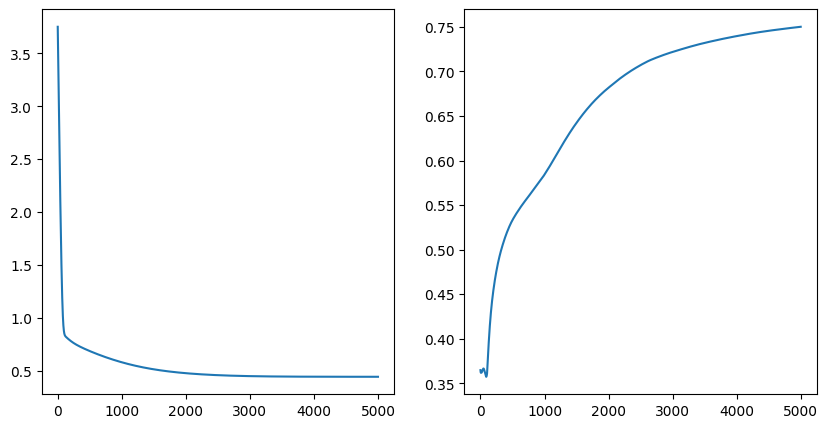

In [130]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
history_linear.loss.plot.line(ax=axes[0])
history_linear.acc.plot.line(ax=axes[1])

In [138]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(5, 500)
        self.act1 = nn.modules.activation.ReLU()
        self.output = nn.Linear(500, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.output(x)
        return x

In [139]:
m = MLPClassifier()
summary(m, input_size=(891, 5))

Layer (type:depth-idx)                   Output Shape              Param #
MLPClassifier                            [891, 2]                  --
├─Linear: 1-1                            [891, 500]                3,000
├─ReLU: 1-2                              [891, 500]                --
├─Linear: 1-3                            [891, 2]                  1,002
Total params: 4,002
Trainable params: 4,002
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.57
Input size (MB): 0.02
Forward/backward pass size (MB): 3.58
Params size (MB): 0.02
Estimated Total Size (MB): 3.61

In [140]:
mlp = MLPClassifier()
optimizer = Adam(mlp.parameters())
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=891)

history_mlp = train(mlp, optimizer, dataloader, 5000)

0: loss=0.7558, acc=0.62
500: loss=0.3842, acc=0.81
1000: loss=0.3595, acc=0.83
1500: loss=0.3489, acc=0.83
2000: loss=0.3412, acc=0.84
2500: loss=0.3335, acc=0.84
3000: loss=0.3300, acc=0.84
3500: loss=0.3279, acc=0.85
4000: loss=0.3260, acc=0.85
4500: loss=0.3230, acc=0.85
